## Plot microsatellite instability classification results

Here, we'll visualize the results of the MSI prediction experiments. Remember that we're trying to classify MSI-H ("high" microsatellite instability, inferred from sequencing assays) against all other classes (MSI-L = "low" microsatellite instability, MSS = "microsatellite stable" tumors, "indeterminate" tumors).

Results analyzed here are generated by the `run_msi_prediction.py` script.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.data_utilities as du

%load_ext autoreload
%autoreload 2

### Load results

In [2]:
# set results directory
results_dir = Path(cfg.results_dirs['msi'], 'msi_5000_top_mad_std').resolve()

In [3]:
results_df = au.load_msi_results(results_dir)

print(results_df.shape)
print(results_df.training_data.unique())
results_df.head()

(1152, 8)
['mut_sigs' 'rppa' 'me_450k' 'mirna' 'expression' 'me_27k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold
0,0.97957,0.92702,UCEC,mut_sigs,signal,1,train,0
1,0.96250,0.86135,UCEC,mut_sigs,signal,1,test,0
2,0.95714,0.90310,UCEC,mut_sigs,signal,1,cv,0
3,0.96114,0.92889,UCEC,mut_sigs,signal,1,train,1
4,0.98217,0.91359,UCEC,mut_sigs,signal,1,test,1


### Plot results per cancer type, on true labels

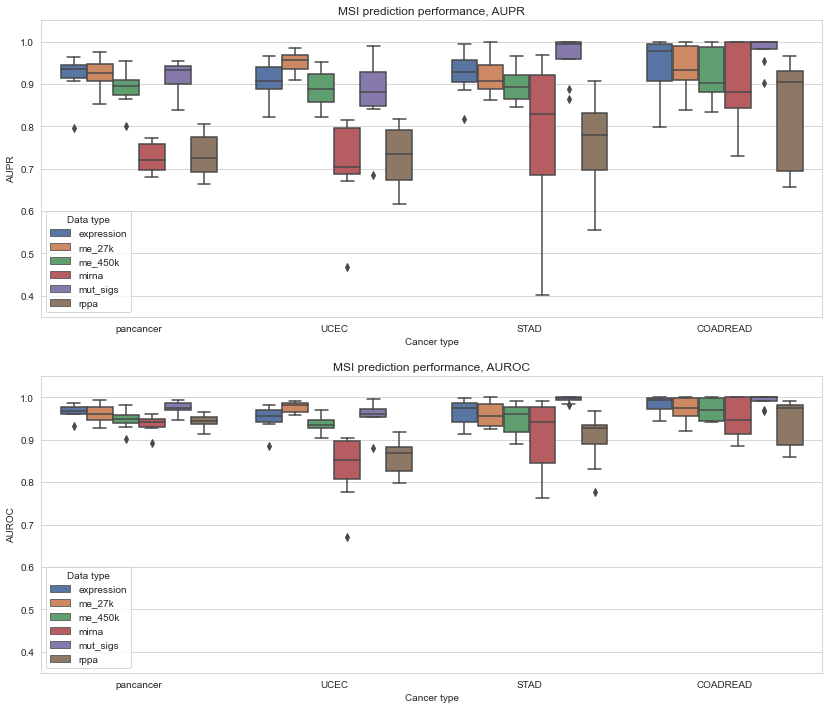

In [4]:
sns.set({'figure.figsize': (14, 12)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(2, 1)

plot_df = (
    results_df[(results_df.data_type == 'test') &
               (results_df.signal == 'signal')]
      .sort_values(by=['signal', 'training_data'])
)

sns.boxplot(data=plot_df, x='identifier', y='aupr', hue='training_data', ax=axarr[0])
axarr[0].set_title('MSI prediction performance, AUPR')
axarr[0].set_xlabel('Cancer type')
axarr[0].set_ylabel('AUPR')
axarr[0].set_ylim(0.35, 1.05)
axarr[0].legend(title='Data type')

sns.boxplot(data=plot_df, x='identifier', y='auroc', hue='training_data', ax=axarr[1])
axarr[1].set_title('MSI prediction performance, AUROC')
axarr[1].set_xlabel('Cancer type')
axarr[1].set_ylabel('AUROC')
axarr[1].set_ylim(0.35, 1.05)
axarr[1].legend(title='Data type')

### Plot results per cancer type, corrected for permuted labels baseline

Different cancer types may have different baseline proportions of MSI-H tumors, so comparing against a baseline where the MSI labels are permuted can help to correct for these varying label proportions.

In [5]:
compare_df = au.compare_all_data_types(results_df,
                                       sig_alpha=0.05,
                                       filter_genes=False,
                                       compare_ind=True,
                                       metric='auroc')
compare_df.rename(columns={'gene': 'cancer_type'}, inplace=True)

compare_aupr_df = au.compare_all_data_types(results_df,
                                            sig_alpha=0.05,
                                            filter_genes=False,
                                            compare_ind=True,
                                            metric='aupr')
compare_aupr_df.rename(columns={'gene': 'cancer_type'}, inplace=True)

print(compare_df.shape)
print(compare_df.training_data.unique())
compare_df.head()

(192, 5)
['mut_sigs' 'rppa' 'me_450k' 'mirna' 'expression' 'me_27k']


,cancer_type,seed,fold,delta_auroc,training_data
0,COADREAD,1,0,0.70635,mut_sigs
1,COADREAD,1,1,0.50250,mut_sigs
2,COADREAD,1,2,0.55244,mut_sigs
3,COADREAD,1,3,0.40678,mut_sigs
4,COADREAD,42,0,0.45303,mut_sigs


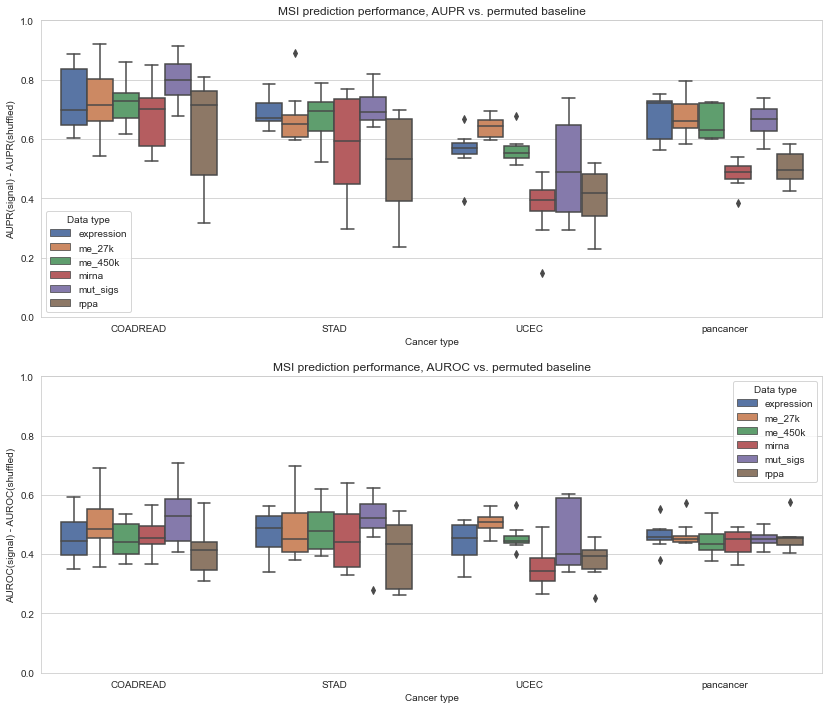

In [6]:
sns.set({'figure.figsize': (14, 12)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(2, 1)

sns.boxplot(data=compare_aupr_df, x='cancer_type', y='delta_aupr',
            hue='training_data',
            hue_order=sorted(compare_aupr_df.training_data.unique()),
            ax=axarr[0])
axarr[0].set_title('MSI prediction performance, AUPR vs. permuted baseline')
axarr[0].set_xlabel('Cancer type')
axarr[0].set_ylabel('AUPR(signal) - AUPR(shuffled)')
axarr[0].set_ylim(0.0, 1.0)
axarr[0].legend(title='Data type')

sns.boxplot(data=compare_df, x='cancer_type', y='delta_auroc',
            hue='training_data',
            hue_order=sorted(compare_df.training_data.unique()),
            ax=axarr[1])
axarr[1].set_title('MSI prediction performance, AUROC vs. permuted baseline')
axarr[1].set_xlabel('Cancer type')
axarr[1].set_ylabel('AUROC(signal) - AUROC(shuffled)')
axarr[1].set_ylim(0.0, 1.0)
axarr[1].legend(title='Data type')

### Look at features selected from mutational signatures data

There are a few mutational signatures that have been directly associated with MSI. Let's see if those are selected frequently in our models, and if they tend to have positive coefficients (i.e. higher prevalence of signature -> higher probability of MSI-H status).

In [7]:
nz_coefs = []
for identifier, seed, coefs in au.generate_nz_coefs_msi(results_dir):
    if 'mut_sigs' not in identifier: continue
    for fold_no, fold_coefs in enumerate(coefs):
        for feat_name, feat_coef in fold_coefs:
            nz_coefs.append([identifier, seed, fold_no, feat_name, feat_coef])
            
nz_coefs_df = pd.DataFrame(nz_coefs, columns=['identifier', 'seed', 'fold', 'name', 'coef'])
nz_coefs_df.head()

,identifier,seed,fold,name,coef
0,pancancer_mut_sigs,1,0,log10_mut,7.5006
1,pancancer_mut_sigs,1,0,SBS10b,-4.2097
2,pancancer_mut_sigs,1,0,SBS2,-2.1888
3,pancancer_mut_sigs,1,0,SBS10a,-2.1872
4,pancancer_mut_sigs,1,0,UCEC,1.8476


In [8]:
# just average each coefficient over seeds/folds for now
coefs_df = (nz_coefs_df
  .groupby(['identifier', 'name'])
  .agg(['count', 'mean'])
  .drop(columns=['seed', 'fold'])
)
coefs_df.sort_values(by=[('coef', 'count'), ('coef', 'mean')], ascending=[False, False]).head(10)

coef           
                             count       mean
identifier         name                      
STAD_mut_sigs      SBS1          8  16.712396
COADREAD_mut_sigs  SBS1          8  16.545288
STAD_mut_sigs      SBS20         8  10.944880
COADREAD_mut_sigs  SBS44         8  10.416250
UCEC_mut_sigs      log10_mut     8   7.780325
STAD_mut_sigs      SBS15         8   6.497724
COADREAD_mut_sigs  SBS15         8   5.277265
                   SBS20         8   4.779740
pancancer_mut_sigs log10_mut     8   4.737375
COADREAD_mut_sigs  SBS5          8   2.549731

In [9]:
coefs_df[coefs_df.index.get_level_values(1).isin(
    ['SBS6', 'SBS14', 'SBS15', 'SBS20', 'SBS21', 'SBS26', 'SBS44']
)]

coef           
                         count       mean
identifier         name                  
COADREAD_mut_sigs  SBS15     8   5.277265
                   SBS20     8   4.779740
                   SBS44     8  10.416250
STAD_mut_sigs      SBS14     4   0.268812
                   SBS15     8   6.497724
                   SBS20     8  10.944880
                   SBS21     3  43.839670
                   SBS6      4   0.482489
UCEC_mut_sigs      SBS14     6  -0.151058
                   SBS15     3  -1.787009
                   SBS20     5  17.104794
                   SBS21     4   4.692537
                   SBS26     8   1.884127
                   SBS44     6  -2.977735
pancancer_mut_sigs SBS14     5   0.423942
                   SBS15     8   0.061598
                   SBS20     7   1.010420
                   SBS21     6   0.547634
                   SBS26     7   0.859565
                   SBS44     5   0.244428
                   SBS6      7   0.108538

In [10]:
coefs_df[coefs_df.index.get_level_values(0) == 'pancancer_mut_sigs'].sort_values(
    by=[('coef', 'count'), ('coef', 'mean')], ascending=[False, False]
).head(10)

coef          
                             count      mean
identifier         name                     
pancancer_mut_sigs log10_mut     8  4.737375
                   UCEC          8  1.154274
                   SBS1          8  0.557913
                   SBS15         8  0.061598
                   SBS17a        8 -0.263997
                   COAD          8 -0.358730
                   SBS2          8 -1.101268
                   SBS28         8 -1.181209
                   SBS40         8 -1.515313
                   SBS10b        8 -3.029950

On [this page](https://cancer.sanger.ac.uk/signatures/sbs/sbs6/), we can see that the single-base mutational signatures commonly associated with MSI/defective DNA mismatch repair are SBS6, SBS14, SBS15, SBS20, SBS21, SBS26, and SBS44.

We can see in the tables above that on average, these signatures tend to have positive coefficients, and some of them (SBS15, SBS20, SBS21, SBS44) consistently have very large positive coefficients (indicating that the presence of these signatures implies a very high probability of MSI). This makes sense, given what is known about these signatures.

This effect is most clear in the individual cancer types, however - the pan-cancer predictor tends to rely more on cancer type and mutation burden, and there is less consistency in which signatures are selected by the model.